In [1]:
#Imports

import os
import cv2
import glob
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from xml.etree import ElementTree as et
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchvision.ops import nms, box_iou

In [2]:
#config

img_size = 512

batch_size = 8

NUM_BOXES = 5
NUM_CLASSES = 5

classes = ['student','Security', 'Staff', 'Facility Worker','Food Service worker']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [3]:
#Dataset and DataLoader

class FaceDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.num_boxes = 5
        self.num_classes = 5
        self.width = width
        self.classes = classes

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/*.jpg")
        self.image_paths += glob.glob(f"{self.dir_path}/*.png")
        self.all_images = [image_path.split(
            '/')[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)

        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0

        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()

        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]

        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            labels.append(self.classes.index(member.find('name').text))

            # xmin = left corner x-coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            # xmax = right corner x-coordinates
            xmax = int(member.find('bndbox').find('xmax').text)
            # ymin = left corner y-coordinates
            ymin = int(member.find('bndbox').find('ymin').text)
            # ymax = right corner y-coordinates
            ymax = int(member.find('bndbox').find('ymax').text)

            # resize the bounding boxes according to the...
            # ... desired `width`, `height`
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            ymax_final = (ymax/image_height)*self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        boxes,labels = self.map_to_model_output(boxes, labels , self.num_boxes)

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final `target` dictionary
        target = {}
        target["bounding_box"] = boxes
        target["class_label"] = labels

        # apply the image transforms
        if self.transforms:
            sample = self.transforms(image=image_resized,
                                     bboxes=target['bounding_box'],
                                     labels=labels)
            image_resized = sample['image']
            target['bounding_box'] = torch.Tensor(sample['bboxes'])

        return image_resized, target
    
    def map_to_model_output(self, boxes, classes, num_boxes):
        # Pad the lists to have a fixed number of boxes
        boxes_padded = self.pad_list_to_length(boxes, max_len=num_boxes, pad_value=[0, 0, 512, 512])
        classes_padded = self.pad_list_to_length(classes, max_len=num_boxes, pad_value=-1)
        return boxes_padded, classes_padded

    def pad_list_to_length(self, list_to_pad, max_len, pad_value):
        list_len = len(list_to_pad)
        if list_len >= max_len:
            return list_to_pad[:max_len]
        else:
            # Calculate padding required
            padding = [pad_value] * (max_len - list_len)

            # Pad the list
            padded_list = list_to_pad + padding

            return padded_list

    def __len__(self):
        return len(self.all_images)

train_transforms = A.Compose([
    A.Flip(0.5),
    A.RandomRotate90(0.5),
    A.MotionBlur(p=0.2),
    A.MedianBlur(blur_limit=3, p=0.1),
    A.Blur(blur_limit=3, p=0.1),
    ToTensorV2(p=1.0),
], bbox_params={
    'format': 'pascal_voc',
    'label_fields': ['labels']
})

valid_transforms = A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc','label_fields': ['labels']})


def collate_fn(batch):
    images,targets = zip(*batch)

    bounding_boxes = [target['bounding_box'] for target in targets]
    class_labels = [target['class_label'] for target in targets]

    return images,bounding_boxes,class_labels

train_dir = 'dataset/train'
valid_dir = 'dataset/valid'

train_dataset = FaceDataset(train_dir,img_size,img_size,classes,transforms=train_transforms)

valid_dataset = FaceDataset(valid_dir,img_size,img_size,classes,transforms=valid_transforms)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)


print("Input Size")
for images, bounding_boxes, class_labels in train_loader:
    print(images[0].shape)
    print(bounding_boxes[0].shape)
    print(class_labels[0].shape)
    break

Input Size


torch.Size([3, 512, 512])
torch.Size([5, 4])
torch.Size([5])


In [4]:
#Model Definition


class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Max pooling for 512x512 images
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Adjust feature map sizes for 512 input
        self.res1 = ResNetBlock(64, 128, 128)
        self.res2 = ResNetBlock(128, 256, 256)
        self.res3 = ResNetBlock(256, 256, 512)
        self.res4 = ResNetBlock(256, 512, 512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Max pooling
        x = self.maxpool(x)

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)

        x = self.avgpool(x)

        return x

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Fixed: Identity mapping
        identity = x
        out = self.layers(x)

        # Ensure identity has the same dimensions as out
        if identity.size() != out.size():
            identity = F.pad(identity, (0, 0, 0, 0, 0, out.size(1) - identity.size(1)))

        out += identity
        out = nn.ReLU(inplace=True)(out)
        return out

class FaceRecogNet(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.cnn = ResNet18()  

        self.bbox_reg = nn.Linear(512, NUM_BOXES*4)
       
        self.cls_head = nn.Linear(512, NUM_CLASSES)  

    def forward(self, x):

        x = self.cnn(x)

        x = x.view(x.size(0), -1)
        
        predicted_boxes = self.bbox_reg(x) 
        predicted_classes = self.cls_head(x)
        
        predicted_boxes = predicted_boxes.reshape(x.size(0), NUM_BOXES, 4)
        predicted_classes = predicted_classes.reshape(x.size(0), NUM_CLASSES)

        return predicted_boxes, predicted_classes

In [5]:
#Objective Function

def Calculate_loss(anchor,positive,negative):

    # Calculate the loss for the bounding boxes
    loss_bbox = F.triplet_margin_loss(anchor[0], positive[0], negative[0], margin = 0.5, p = 4, reduction='mean')

    loss_class = F.triplet_margin_with_distance_loss(anchor[0], positive[0], negative[0],distance_function=nn.PairwiseDistance(),margin= 0.1 ,reduction='mean')

    total_loss = loss_bbox + loss_class

    return total_loss

In [6]:
def train_tune(config, out_dir='outputs'):

    model = FaceRecogNet().to(device)

    def init_weights(m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            torch.nn.init.zeros_(m.bias)

    model.apply(init_weights)

    optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum = config['momentum'], weight_decay = 0.0005)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1,last_epoch=-1)

    train_losses = []
    valid_losses = []

    num_epochs = config["epochs"]
    for epoch in range(num_epochs):
        model.train()
        for images, bounding_boxes, class_labels in train_loader:
            images = torch.stack(images).to(device)
            bounding_boxes = torch.stack(bounding_boxes).to(device)
            class_labels = torch.stack(class_labels).to(device)

            optimizer.zero_grad()

            anchor = model(images)

            positive = model(images)

            negative = model(images)

            # Calculate loss
            loss = Calculate_loss(anchor, positive, negative)

            # Backpropagation
            loss.backward()

            # Update weights
            optimizer.step()

            train_losses.append(loss.item())

        print(f"Epoch: {epoch+1}/{num_epochs}, Training Loss: {loss.item():.4f}")


        # Validation
        model.eval()
        with torch.no_grad():
            for images, bounding_boxes, class_labels in valid_loader:

                images = torch.stack(images).to(device)
                bounding_boxes = torch.stack(bounding_boxes).to(device)
                class_labels = torch.stack(class_labels).to(device)

                anchor_valid = model(images)
                positive_valid = model(images)
                negative_valid = model(images)

                # Calculate loss
                loss = Calculate_loss(anchor_valid,positive_valid,negative_valid)

                valid_losses.append(loss.item())


        print(f"Epoch: {epoch+1}/{num_epochs}, Validation Loss: {loss.item():.4f}")

        lr_scheduler.step()


    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.savefig( f"{out_dir}/_loss_plot_{num_epochs}.png")
    torch.save(model.state_dict(), f"{out_dir}/_{num_epochs}.pth")

Training with config:  {'lr': 1e-07, 'momentum': 0.7, 'epochs': 10}


Epoch: 1/10, Training Loss: 0.6000
Epoch: 1/10, Validation Loss: 0.6000
Epoch: 2/10, Training Loss: 0.6000
Epoch: 2/10, Validation Loss: 0.6000
Epoch: 3/10, Training Loss: 0.6000
Epoch: 3/10, Validation Loss: 0.6000
Epoch: 4/10, Training Loss: 0.6000
Epoch: 4/10, Validation Loss: 0.6000
Epoch: 5/10, Training Loss: 0.6000
Epoch: 5/10, Validation Loss: 0.6000
Epoch: 6/10, Training Loss: 0.6000
Epoch: 6/10, Validation Loss: 0.6000
Epoch: 7/10, Training Loss: 0.6000
Epoch: 7/10, Validation Loss: 0.6000
Epoch: 8/10, Training Loss: 0.6000
Epoch: 8/10, Validation Loss: 0.6000
Epoch: 9/10, Training Loss: 0.6000
Epoch: 9/10, Validation Loss: 0.6000
Epoch: 10/10, Training Loss: 0.6000
Epoch: 10/10, Validation Loss: 0.6000
Training with config:  {'lr': 1e-07, 'momentum': 0.7, 'epochs': 15}
Epoch: 1/15, Training Loss: 0.6000
Epoch: 1/15, Validation Loss: 0.6000
Epoch: 2/15, Training Loss: 0.6000
Epoch: 2/15, Validation Loss: 0.6000
Epoch: 3/15, Training Loss: 0.6000
Epoch: 3/15, Validation Loss: 0

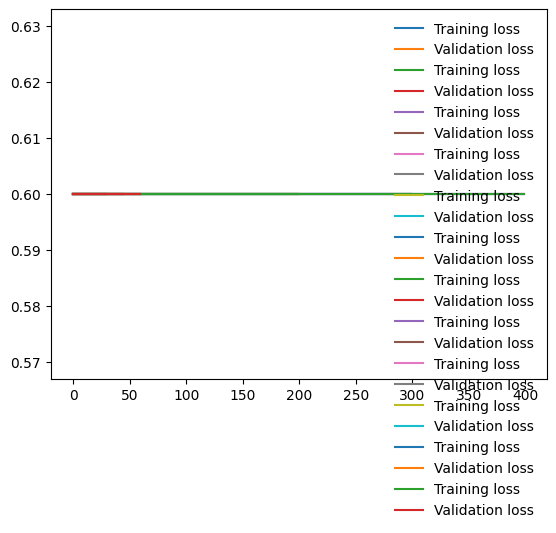

In [7]:
#Hyperparameter Tuning

hyperparameter_space = {
    "lr": [1e-7, 2e-9],
    "momentum": [0.7, 0.2],
    "epochs": [10, 15, 20]
}


for lr in hyperparameter_space["lr"]:
    for momentum in hyperparameter_space["momentum"]:
        for epochs in hyperparameter_space["epochs"]:
            config = {"lr": lr, "momentum": momentum, "epochs": epochs}
            print("Training with config: ", config)
            train_tune(config, out_dir='outputs')
            torch.cuda.empty_cache()

In [12]:
#Testing the Recall and Preicision score for the best model

model = FaceRecogNet().to('cpu')

model.load_state_dict(torch.load('outputs/model.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
#Calculate the IOU score for the predicted bounding boxes and the ground truth

def calculate_iou(box1, box2):
    intersection = box_iou(box1.unsqueeze(0), box2.unsqueeze(0))
    return intersection.item()

def calculate_precision_recall(targets, predictions, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for batch_idx in range(len(predictions['boxes'])):
        pred_boxes = predictions['boxes'][batch_idx]
        pred_labels = predictions['labels'][batch_idx]

        for pred_box, pred_label in zip(pred_boxes, pred_labels):
            iou_max = 0
            matching_target_index = None

            for i, (target_box, target_label) in enumerate(zip(targets['boxes'][batch_idx], targets['labels'][batch_idx])):
                iou = calculate_iou(pred_box, target_box)
                if iou > iou_threshold and iou > iou_max:
                    iou_max = iou
                    matching_target_index = i

            if matching_target_index is not None:
                true_positives += 1
                targets['boxes'][batch_idx] = torch.cat([targets['boxes'][batch_idx][:matching_target_index], targets['boxes'][batch_idx][matching_target_index+1:]])
                targets['labels'][batch_idx] = torch.cat([targets['labels'][batch_idx][:matching_target_index], targets['labels'][batch_idx][matching_target_index+1:]])
            else:
                false_positives += 1

    false_negatives = sum(len(targets['boxes'][batch_idx]) for batch_idx in range(len(targets['boxes'])))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

In [15]:
#Getting the best model and calculating precision and recall based on IOU score

target_images,target_boxes, target_labels = next(iter(valid_loader))

target_images = torch.stack(target_images).to('cpu')
target_boxes = torch.stack(target_boxes).to('cpu')
target_labels = torch.stack(target_labels).to('cpu')

prediction_boxes, prediction_labels = model(target_images)

predictions = {'boxes': prediction_boxes , 'labels': prediction_labels}

targets = {'boxes': target_boxes , 'labels': target_labels}
precision, recall = calculate_precision_recall(targets, predictions)

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')

Precision: 0.4, Recall: 0.6
